##### Created by Jake Fredrich
##### Last Updated 4/10/2020
### About:
The overall objective of this project is to project revenue for several Countries, 1 Quarter into the future.  Exponential Smoothing,ARIMA modeling, and Linear Regression will be utilized do so dynamically. 

This notebook will be used to explore the different models listed above on one specific country.  Upon completion, a dynamic version of the final model will be created in a .py file, also located in this github folder.

The data source is a currency file found on the Kaggle notebook below, with modifications made to format the data in a way that was useful for me to use in my career as a Data Scientist at IBM.  These values in No Way represent true financial data at IBM.

Referenced - Topic 9 Part 1. Time series analysis in Python. found on Kaggle
https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python/data

In [30]:
# Import relevant Packages

import warnings # do not disturb
warnings.filterwarnings('ignore')

# used for accuracy metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulation
import matplotlib.pyplot as plt  # plots
import seaborn as sns  # additional plots
from math import sqrt
from math import isnan
from dateutil.relativedelta import relativedelta  # working with dates and style
from scipy.optimize import minimize  # for function minimization
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product  # useful functions
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Store Data
#### Lets look at Revenue from Germany

In [31]:
rev_df = pd.read_csv('currency.csv')
# select Germany and drop additional columns
rev_df = rev_df[rev_df['Country'] == "Germany"].drop(columns='Country') # select Germany and drop country column
rev_df.tail()

,Date,Revenue
22,11/1/2019,48553277
23,12/1/2019,43012450
24,1/1/2020,25842832
25,2/1/2020,33157740
26,3/1/2020,24611138


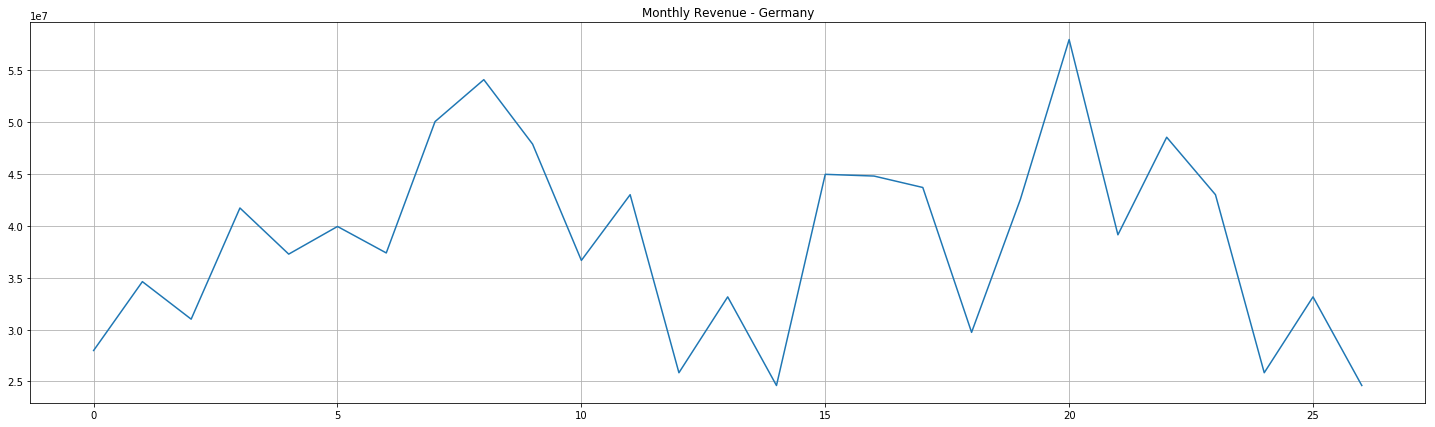

In [32]:
plt.figure(figsize=(25, 7))
plt.plot(rev_df.Revenue)
plt.title('Monthly Revenue - Germany')
plt.grid(True)
plt.show()

## Forecasting Quality Metrics
### These are common metrics used to measure quality of the forecasts we create.
### Most of the measurements can be created using the sklearn package

##### R squared: 
coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), (−∞,1]

In [35]:
sklearn.metrics.r2_score

<function sklearn.metrics.regression.r2_score(y_true, y_pred, sample_weight=None, multioutput='uniform_average')>

##### Mean Absolute Error:
this is an easy to interperet metric, it uses the same unit of measurement as the initial series,  [0,+∞)

In [36]:
sklearn.metrics.mean_absolute_error

<function sklearn.metrics.regression.mean_absolute_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average')>

##### Mean Squared Error:
very commonly used metric, gives a higher penalty to large errrors and vice versa

In [37]:
sklearn.metrics.median_absolute_error

<function sklearn.metrics.regression.median_absolute_error(y_true, y_pred)>

##### Mean Squared Logarithmic Error:
similar to MSE but more weight is given to small mistakes as well.
Typically used when exponential trends exist. [0,+∞)

In [38]:
sklearn.metrics.mean_squared_log_error

<function sklearn.metrics.regression.mean_squared_log_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average')>

##### Mean Absolute  Percentage Error:
This is MAE calculated as a percentage.  
This is easy for management to interperate, and ultimately used in the final .py file
to determine which model to use.

In [39]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


### Evaluation
Starting with the hypothesis that tomorrow will be the same as today(very unlikely), we begin to analyze by determining what it's moving average is.  Moving average